In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

import math

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
                    # transforms.Normalize((0.5,), (0.5,)),
            ])

In [3]:
def CreateDataLoaders(Option, p_BatchSize):
    if Option == 1:
        train_dataset = datasets.MNIST("./", train=True, transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.MNIST("./", train=False, transform = transform, download=True)

    elif Option == 2:
        train_dataset = datasets.FashionMNIST("./", train=True, transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.FashionMNIST("./", train=False, transform = transform, download=True)
    
    elif Option == 3:
        train_dataset = datasets.STL10("./", split="train", transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.STL10("./", split="test", transform = transform, download=True)
    
    elif Option == 4:
        train_dataset = datasets.SVHN("./", split="train", transform = transform, download=True)
        print(len(train_dataset))
        # print(int(len(train_dataset) * 0.85))
        # print(int(len(train_dataset) * 0.15))
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), math.ceil(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.SVHN("./", split="test", transform = transform, download=True)

    elif Option == 5:
        train_dataset = datasets.CIFAR10("./", train=True, transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.CIFAR10("./", train=False, transform = transform, download=True)

    elif Option == 6:
        train_dataset = datasets.CIFAR100("./", train=True, transform = transform, download=True)
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), int(len(train_dataset) * 0.15)], generator=torch.Generator().manual_seed(1))
        test_dataset = datasets.CIFAR100("./", train=False, transform = transform, download=True)
    
    Train_DataLoader = torch.utils.data.DataLoader(train_subset, batch_size = p_BatchSize, shuffle = True)
    Val_DataLoader = torch.utils.data.DataLoader(val_subset, batch_size = p_BatchSize, shuffle = True)
    Test_DataLoader = torch.utils.data.DataLoader(test_dataset, batch_size = p_BatchSize, shuffle = True)

    return Train_DataLoader, Val_DataLoader, Test_DataLoader

In [4]:
def PlotGraph(X, Y1, Y2):
    plt.plot(X, Y1, label = 'Train')
    plt.plot(X, Y2, label = "Val")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.legend(loc='best')
    plt.show()

In [ ]:
# ""

# train_NumOfSamples = len(train_subset)
# val_NumOfSamples = len(val_subset)
# test_NumOfSamples = len(test_dataset)



In [ ]:
# print(len(train_subset))
# print(len(val_subset))
# print(len(test_dataset))

In [ ]:
# dataiter = iter(Test_DataLoader)
# images, labels = next(dataiter)

# print(images.shape)
# print(labels.shape)
# print(labels)

In [5]:
class MLP(nn.Module):
    def __init__(self, InputDim, OutputDim):
        super(MLP, self).__init__()
        self.InputDim = InputDim
        self.OutputDim = OutputDim
        self.Linear1 = nn.Linear(InputDim, 800)
        self.Linear2 = nn.Linear(800, 800)
        self.Linear3 = nn.Linear(800, 800)
        self.Linear4 = nn.Linear(800, self.OutputDim)
        self.ActFunc = nn.functional.relu
        self.batch = nn.BatchNorm1d(800)
        self.SftMax = nn.functional.softmax

    def forward(self, x):
        x = self.ActFunc(self.batch(self.Linear1(x)))
        x = self.ActFunc(self.batch(self.Linear2(x)))
        x = self.ActFunc(self.batch(self.Linear3(x)))

        output = self.Linear4(x)
        
        return output
    
    def InitWeights(self):
        torch.nn.init.uniform_(self.Linear1.weight,-0.5, 0.5)
        torch.nn.init.uniform_(self.Linear2.weight,-0.5, 0.5)

In [6]:
def TrainModel(p_model, loss_criteria, Optimizer, device,  p_TrainDL):
    TrainCorr = 0
    TotNumOfSamples = 0

    for images, labels in tqdm(p_TrainDL):
        Optimizer.zero_grad()

        images = images.reshape(images.shape[0], -1).to(device)
        labels = labels.to(device)

        pred = model(images)
        # print(type(pred))
        # print(pred.shape)
        # print(pred)
        # pred=pred.to(torch.float)
        # labels=labels.to(torch.float)
        predClass = torch.max(pred.data, 1)[1]
        # predClass = np.argmax(pred, axis=-1)
        # predClass = pred.max(1)
        # print("Pred", predClass)
        # print(type(labels))
        # print("labels", labels)

        # predClass=predClass.to(torch.float)
        loss = loss_criteria(pred, labels)
        TrainCorr += (predClass==labels).sum()
        TotNumOfSamples += len(labels)

        loss.backward()
        Optimizer.step()
    
    return TrainCorr/TotNumOfSamples

def EvaluateModel(p_model, p_loader, device):
    Correct = 0
    TotalNumOfSamples = 0

    for images, labels in tqdm(p_loader):
        images = images.reshape(images.shape[0], -1).to(device)
        labels = labels.to(device)

        pred = p_model(images)
        predClass = torch.max(pred.data, 1)[1]
        Correct += (predClass==labels).sum()
        TotalNumOfSamples += len(labels)
        # loss = loss_criteria(predClass, labels)
        # Accuracy += loss.cpu().data.item()

    return Correct/TotalNumOfSamples

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 50

Epoch_List = [i+1 for i in range(EPOCHS)]

In [ ]:
# -------------------------------------------- MNIST Dataset -----------------------------------------------------------
Option = 1
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_MNIST.pt"

model = MLP(784, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)

    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

print()
Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
Test_Accuracy = EvaluateModel(model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy)

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 9912422/9912422 [00:00<00:00, 104607721.45it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38950383.87it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25835835.26it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6887392.90it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 141/141 [00:01<00:00, 106.47it/s]


EPOCH -  0 . Train Accuracy =  0.9366274476051331 , Validation Accuracy =  0.9646666646003723
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 105.50it/s]


EPOCH -  1 . Train Accuracy =  0.9782353043556213 , Validation Accuracy =  0.9697777628898621
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 103.14it/s]


EPOCH -  2 . Train Accuracy =  0.9877058863639832 , Validation Accuracy =  0.9721111059188843
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.02it/s]


EPOCH -  3 . Train Accuracy =  0.9918627738952637 , Validation Accuracy =  0.9741111397743225
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 98.55it/s]


EPOCH -  4 . Train Accuracy =  0.9936470985412598 , Validation Accuracy =  0.972444474697113


100%|██████████| 141/141 [00:01<00:00, 88.85it/s] 


EPOCH -  5 . Train Accuracy =  0.994372546672821 , Validation Accuracy =  0.9735555648803711


100%|██████████| 141/141 [00:01<00:00, 82.94it/s]


EPOCH -  6 . Train Accuracy =  0.9951764941215515 , Validation Accuracy =  0.976555585861206
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 107.21it/s]


EPOCH -  7 . Train Accuracy =  0.9960980415344238 , Validation Accuracy =  0.9782222509384155
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 103.23it/s]


EPOCH -  8 . Train Accuracy =  0.995980441570282 , Validation Accuracy =  0.9746666550636292


100%|██████████| 141/141 [00:01<00:00, 104.60it/s]


EPOCH -  9 . Train Accuracy =  0.9964902400970459 , Validation Accuracy =  0.9734444618225098


100%|██████████| 141/141 [00:01<00:00, 105.09it/s]


EPOCH -  10 . Train Accuracy =  0.9966862797737122 , Validation Accuracy =  0.9754444360733032


100%|██████████| 141/141 [00:01<00:00, 107.37it/s]


EPOCH -  11 . Train Accuracy =  0.9973529577255249 , Validation Accuracy =  0.9764444828033447


100%|██████████| 141/141 [00:01<00:00, 104.75it/s]


EPOCH -  12 . Train Accuracy =  0.9969608187675476 , Validation Accuracy =  0.9764444828033447


100%|██████████| 141/141 [00:01<00:00, 78.25it/s]


EPOCH -  13 . Train Accuracy =  0.9971372485160828 , Validation Accuracy =  0.9785555601119995
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 96.41it/s]


EPOCH -  14 . Train Accuracy =  0.9970196485519409 , Validation Accuracy =  0.9783333539962769


100%|██████████| 141/141 [00:01<00:00, 104.80it/s]


EPOCH -  15 . Train Accuracy =  0.9975294470787048 , Validation Accuracy =  0.9782222509384155


100%|██████████| 141/141 [00:01<00:00, 102.05it/s]


EPOCH -  16 . Train Accuracy =  0.998078465461731 , Validation Accuracy =  0.9762222170829773


100%|██████████| 141/141 [00:01<00:00, 107.28it/s]


EPOCH -  17 . Train Accuracy =  0.9974902272224426 , Validation Accuracy =  0.9779999852180481


100%|██████████| 141/141 [00:01<00:00, 104.54it/s]


EPOCH -  18 . Train Accuracy =  0.9985098242759705 , Validation Accuracy =  0.9766666889190674


100%|██████████| 141/141 [00:01<00:00, 105.73it/s]


EPOCH -  19 . Train Accuracy =  0.9978627562522888 , Validation Accuracy =  0.97688889503479


100%|██████████| 141/141 [00:01<00:00, 94.04it/s] 


EPOCH -  20 . Train Accuracy =  0.9980196356773376 , Validation Accuracy =  0.9788889288902283
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 79.38it/s]


EPOCH -  21 . Train Accuracy =  0.9977254867553711 , Validation Accuracy =  0.9754444360733032


100%|██████████| 141/141 [00:01<00:00, 107.70it/s]


EPOCH -  22 . Train Accuracy =  0.9978823661804199 , Validation Accuracy =  0.9782222509384155


100%|██████████| 141/141 [00:01<00:00, 107.16it/s]


EPOCH -  23 . Train Accuracy =  0.9983529448509216 , Validation Accuracy =  0.9763333201408386


100%|██████████| 141/141 [00:01<00:00, 106.86it/s]


EPOCH -  24 . Train Accuracy =  0.9985490441322327 , Validation Accuracy =  0.976555585861206


100%|██████████| 141/141 [00:01<00:00, 109.54it/s]


EPOCH -  25 . Train Accuracy =  0.9983529448509216 , Validation Accuracy =  0.97688889503479


100%|██████████| 141/141 [00:01<00:00, 105.89it/s]


EPOCH -  26 . Train Accuracy =  0.998431384563446 , Validation Accuracy =  0.9797778129577637
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 103.70it/s]


EPOCH -  27 . Train Accuracy =  0.9986470937728882 , Validation Accuracy =  0.9797778129577637


100%|██████████| 141/141 [00:01<00:00, 77.48it/s]


EPOCH -  28 . Train Accuracy =  0.9987451434135437 , Validation Accuracy =  0.9792222380638123


100%|██████████| 141/141 [00:01<00:00, 106.51it/s]


EPOCH -  29 . Train Accuracy =  0.9990196228027344 , Validation Accuracy =  0.9795555472373962


100%|██████████| 141/141 [00:01<00:00, 105.25it/s]


EPOCH -  30 . Train Accuracy =  0.9985098242759705 , Validation Accuracy =  0.9769999980926514


100%|██████████| 141/141 [00:01<00:00, 104.87it/s]


EPOCH -  31 . Train Accuracy =  0.9985490441322327 , Validation Accuracy =  0.97688889503479


100%|██████████| 141/141 [00:01<00:00, 104.10it/s]


EPOCH -  32 . Train Accuracy =  0.9994313716888428 , Validation Accuracy =  0.9781111478805542


100%|██████████| 141/141 [00:01<00:00, 105.68it/s]


EPOCH -  33 . Train Accuracy =  0.9987255334854126 , Validation Accuracy =  0.9803333282470703
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 106.16it/s]


EPOCH -  34 . Train Accuracy =  0.998607873916626 , Validation Accuracy =  0.9791111350059509


100%|██████████| 141/141 [00:01<00:00, 80.40it/s]


EPOCH -  35 . Train Accuracy =  0.9985882639884949 , Validation Accuracy =  0.9803333282470703


100%|██████████| 141/141 [00:01<00:00, 90.77it/s]


EPOCH -  36 . Train Accuracy =  0.9991568922996521 , Validation Accuracy =  0.9785555601119995


100%|██████████| 141/141 [00:01<00:00, 103.30it/s]


EPOCH -  37 . Train Accuracy =  0.9989804029464722 , Validation Accuracy =  0.9811111092567444
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 105.01it/s]


EPOCH -  38 . Train Accuracy =  0.9987451434135437 , Validation Accuracy =  0.9776666760444641


100%|██████████| 141/141 [00:01<00:00, 103.92it/s]


EPOCH -  39 . Train Accuracy =  0.99894118309021 , Validation Accuracy =  0.9803333282470703


100%|██████████| 141/141 [00:01<00:00, 106.60it/s]


EPOCH -  40 . Train Accuracy =  0.9991568922996521 , Validation Accuracy =  0.980222225189209


100%|██████████| 141/141 [00:01<00:00, 105.65it/s]


EPOCH -  41 . Train Accuracy =  0.9992745518684387 , Validation Accuracy =  0.9785555601119995


100%|██████████| 141/141 [00:01<00:00, 103.15it/s]


EPOCH -  42 . Train Accuracy =  0.9984509944915771 , Validation Accuracy =  0.9790000319480896


100%|██████████| 141/141 [00:01<00:00, 77.43it/s]


EPOCH -  43 . Train Accuracy =  0.9992157220840454 , Validation Accuracy =  0.9795555472373962


100%|██████████| 141/141 [00:01<00:00, 104.70it/s]


EPOCH -  44 . Train Accuracy =  0.9995098114013672 , Validation Accuracy =  0.9792222380638123


100%|██████████| 141/141 [00:01<00:00, 105.06it/s]


EPOCH -  45 . Train Accuracy =  0.9990784525871277 , Validation Accuracy =  0.9777777791023254


100%|██████████| 141/141 [00:01<00:00, 104.57it/s]


EPOCH -  46 . Train Accuracy =  0.9987451434135437 , Validation Accuracy =  0.9778888821601868


100%|██████████| 141/141 [00:01<00:00, 108.09it/s]


EPOCH -  47 . Train Accuracy =  0.9987255334854126 , Validation Accuracy =  0.9796666502952576


100%|██████████| 141/141 [00:01<00:00, 107.11it/s]


EPOCH -  48 . Train Accuracy =  0.9991176724433899 , Validation Accuracy =  0.9810000061988831


100%|██████████| 141/141 [00:01<00:00, 107.71it/s]


EPOCH -  49 . Train Accuracy =  0.999333381652832 , Validation Accuracy =  0.9804444313049316



100%|██████████| 157/157 [00:02<00:00, 78.30it/s]

Test Accuracy =  tensor(0.9823, device='cuda:0')
Generalization Gap =  0.016994178295135498


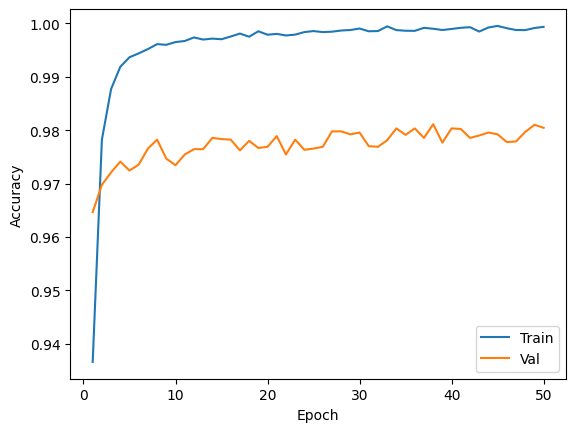

In [ ]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [ ]:
# -------------------------------------------- FMNIST Dataset -----------------------------------------------------------
Option = 2
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_FMNIST.pt"

model = MLP(784, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)


    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

print()
Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 26421880/26421880 [00:01<00:00, 15975588.73it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267790.83it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5021148.39it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8253928.51it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 141/141 [00:01<00:00, 106.92it/s]


EPOCH -  1 . Train Accuracy =  0.8477451205253601 , Validation Accuracy =  0.862333357334137
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.81it/s]


EPOCH -  2 . Train Accuracy =  0.8879411816596985 , Validation Accuracy =  0.8740000128746033
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 106.16it/s]


EPOCH -  3 . Train Accuracy =  0.9039216041564941 , Validation Accuracy =  0.8857777714729309
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 92.15it/s] 


EPOCH -  4 . Train Accuracy =  0.9189411997795105 , Validation Accuracy =  0.8870000243186951
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 79.51it/s]


EPOCH -  5 . Train Accuracy =  0.9273725748062134 , Validation Accuracy =  0.8888888955116272
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 102.82it/s]


EPOCH -  6 . Train Accuracy =  0.9356862902641296 , Validation Accuracy =  0.8914444446563721
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 106.37it/s]


EPOCH -  7 . Train Accuracy =  0.9434509873390198 , Validation Accuracy =  0.8904444575309753


100%|██████████| 141/141 [00:01<00:00, 106.45it/s]


EPOCH -  8 . Train Accuracy =  0.9512941241264343 , Validation Accuracy =  0.8889999985694885


100%|██████████| 141/141 [00:01<00:00, 105.57it/s]


EPOCH -  9 . Train Accuracy =  0.9580392241477966 , Validation Accuracy =  0.8866666555404663


100%|██████████| 141/141 [00:01<00:00, 105.21it/s]


EPOCH -  10 . Train Accuracy =  0.9610980749130249 , Validation Accuracy =  0.8907777667045593


100%|██████████| 141/141 [00:01<00:00, 106.07it/s]


EPOCH -  11 . Train Accuracy =  0.9651373028755188 , Validation Accuracy =  0.8896666765213013


100%|██████████| 141/141 [00:01<00:00, 99.15it/s] 


EPOCH -  12 . Train Accuracy =  0.9682941436767578 , Validation Accuracy =  0.8904444575309753


100%|██████████| 141/141 [00:01<00:00, 80.38it/s]


EPOCH -  13 . Train Accuracy =  0.9723529815673828 , Validation Accuracy =  0.8898888826370239


100%|██████████| 141/141 [00:01<00:00, 105.72it/s]


EPOCH -  14 . Train Accuracy =  0.9755294322967529 , Validation Accuracy =  0.8899999856948853


100%|██████████| 141/141 [00:01<00:00, 108.39it/s]


EPOCH -  15 . Train Accuracy =  0.9755686521530151 , Validation Accuracy =  0.8888888955116272


100%|██████████| 141/141 [00:01<00:00, 110.05it/s]


EPOCH -  16 . Train Accuracy =  0.9774118065834045 , Validation Accuracy =  0.8917778134346008
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 104.17it/s]


EPOCH -  17 . Train Accuracy =  0.9800784587860107 , Validation Accuracy =  0.8934444785118103
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 106.65it/s]


EPOCH -  18 . Train Accuracy =  0.9810980558395386 , Validation Accuracy =  0.8907777667045593


100%|██████████| 141/141 [00:01<00:00, 100.99it/s]


EPOCH -  19 . Train Accuracy =  0.9827058911323547 , Validation Accuracy =  0.8883333206176758


100%|██████████| 141/141 [00:01<00:00, 80.74it/s]


EPOCH -  20 . Train Accuracy =  0.9833333492279053 , Validation Accuracy =  0.8897777795791626


100%|██████████| 141/141 [00:01<00:00, 106.93it/s]


EPOCH -  21 . Train Accuracy =  0.9844902157783508 , Validation Accuracy =  0.894444465637207
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 107.59it/s]


EPOCH -  22 . Train Accuracy =  0.985039234161377 , Validation Accuracy =  0.8898888826370239


100%|██████████| 141/141 [00:01<00:00, 104.17it/s]


EPOCH -  23 . Train Accuracy =  0.9858627915382385 , Validation Accuracy =  0.8905555605888367


100%|██████████| 141/141 [00:01<00:00, 106.40it/s]


EPOCH -  24 . Train Accuracy =  0.9869412183761597 , Validation Accuracy =  0.8912222385406494


100%|██████████| 141/141 [00:01<00:00, 106.13it/s]


EPOCH -  25 . Train Accuracy =  0.9856863021850586 , Validation Accuracy =  0.8915555477142334


100%|██████████| 141/141 [00:01<00:00, 91.25it/s] 


EPOCH -  26 . Train Accuracy =  0.9888431429862976 , Validation Accuracy =  0.8924444317817688


100%|██████████| 141/141 [00:01<00:00, 80.57it/s]


EPOCH -  27 . Train Accuracy =  0.9898431301116943 , Validation Accuracy =  0.8937777876853943


100%|██████████| 141/141 [00:01<00:00, 103.94it/s]


EPOCH -  28 . Train Accuracy =  0.9900000095367432 , Validation Accuracy =  0.8930000066757202


100%|██████████| 141/141 [00:01<00:00, 106.51it/s]


EPOCH -  29 . Train Accuracy =  0.9878235459327698 , Validation Accuracy =  0.8892222046852112


100%|██████████| 141/141 [00:01<00:00, 107.89it/s]


EPOCH -  30 . Train Accuracy =  0.9898627400398254 , Validation Accuracy =  0.8916666507720947


100%|██████████| 141/141 [00:01<00:00, 106.35it/s]


EPOCH -  31 . Train Accuracy =  0.9903333783149719 , Validation Accuracy =  0.8943333625793457


100%|██████████| 141/141 [00:01<00:00, 107.12it/s]


EPOCH -  32 . Train Accuracy =  0.9900588393211365 , Validation Accuracy =  0.8998888731002808
Model Re-Saved


100%|██████████| 141/141 [00:01<00:00, 97.01it/s] 


EPOCH -  33 . Train Accuracy =  0.9909803867340088 , Validation Accuracy =  0.894777774810791


100%|██████████| 141/141 [00:01<00:00, 79.63it/s]


EPOCH -  34 . Train Accuracy =  0.9924706220626831 , Validation Accuracy =  0.8955555558204651


100%|██████████| 141/141 [00:01<00:00, 107.76it/s]


EPOCH -  35 . Train Accuracy =  0.9897451400756836 , Validation Accuracy =  0.8934444785118103


100%|██████████| 141/141 [00:01<00:00, 106.37it/s]


EPOCH -  36 . Train Accuracy =  0.9916862845420837 , Validation Accuracy =  0.8974444270133972


100%|██████████| 141/141 [00:01<00:00, 108.17it/s]


EPOCH -  37 . Train Accuracy =  0.9914706349372864 , Validation Accuracy =  0.8918889164924622


100%|██████████| 141/141 [00:01<00:00, 108.05it/s]


EPOCH -  38 . Train Accuracy =  0.9917647242546082 , Validation Accuracy =  0.8948888778686523


100%|██████████| 141/141 [00:01<00:00, 108.15it/s]


EPOCH -  39 . Train Accuracy =  0.9917058944702148 , Validation Accuracy =  0.8894444704055786


100%|██████████| 141/141 [00:01<00:00, 98.93it/s] 


EPOCH -  40 . Train Accuracy =  0.9924314022064209 , Validation Accuracy =  0.8916666507720947


100%|██████████| 141/141 [00:01<00:00, 78.23it/s]


EPOCH -  41 . Train Accuracy =  0.9922745227813721 , Validation Accuracy =  0.8926666975021362


100%|██████████| 141/141 [00:01<00:00, 104.84it/s]


EPOCH -  42 . Train Accuracy =  0.9931961297988892 , Validation Accuracy =  0.8933333158493042


100%|██████████| 141/141 [00:01<00:00, 108.74it/s]


EPOCH -  43 . Train Accuracy =  0.992078423500061 , Validation Accuracy =  0.8962222337722778


100%|██████████| 141/141 [00:01<00:00, 106.93it/s]


EPOCH -  44 . Train Accuracy =  0.9949019551277161 , Validation Accuracy =  0.8968889117240906


100%|██████████| 141/141 [00:01<00:00, 106.18it/s]


EPOCH -  45 . Train Accuracy =  0.9922353029251099 , Validation Accuracy =  0.8930000066757202


100%|██████████| 141/141 [00:01<00:00, 107.49it/s]


EPOCH -  46 . Train Accuracy =  0.9942941665649414 , Validation Accuracy =  0.8934444785118103


100%|██████████| 141/141 [00:01<00:00, 107.64it/s]


EPOCH -  47 . Train Accuracy =  0.993843138217926 , Validation Accuracy =  0.8956666588783264


100%|██████████| 141/141 [00:01<00:00, 77.93it/s]


EPOCH -  48 . Train Accuracy =  0.993509829044342 , Validation Accuracy =  0.8945555686950684


100%|██████████| 141/141 [00:01<00:00, 105.10it/s]


EPOCH -  49 . Train Accuracy =  0.9954901933670044 , Validation Accuracy =  0.8965555429458618


100%|██████████| 141/141 [00:01<00:00, 106.05it/s]


EPOCH -  50 . Train Accuracy =  0.9935294389724731 , Validation Accuracy =  0.8923333287239075



100%|██████████| 797/797 [00:08<00:00, 97.56it/s] 


Train Accuracy =  0.9937059283256531


100%|██████████| 157/157 [00:01<00:00, 108.41it/s]

Test Accuracy =  0.8934999704360962
Generalization Gap =  0.10020595788955688


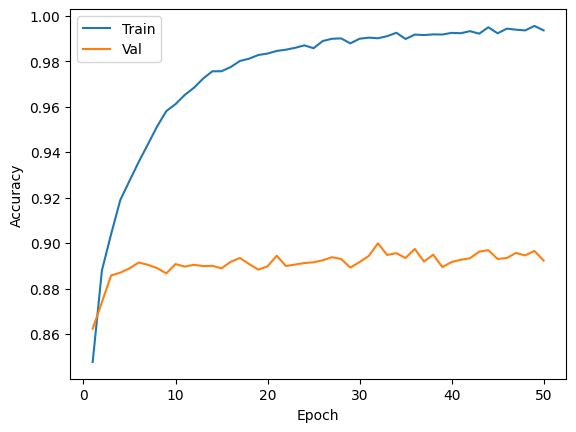

In [ ]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [ ]:
# -------------------------------------------- STL 10 Dataset -----------------------------------------------------------
Option = 3
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_STL10.pt"

model = MLP(27648, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)


    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

print()
Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 2640397119/2640397119 [00:46<00:00, 57049531.19it/s]


Extracting ./stl10_binary.tar.gz to ./
Files already downloaded and verified


100%|██████████| 12/12 [00:00<00:00, 35.74it/s]


EPOCH -  1 . Train Accuracy =  0.328000009059906 , Validation Accuracy =  0.390666663646698
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 37.46it/s]


EPOCH -  2 . Train Accuracy =  0.48235294222831726 , Validation Accuracy =  0.40666666626930237
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 36.45it/s]


EPOCH -  3 . Train Accuracy =  0.6148235201835632 , Validation Accuracy =  0.4399999976158142
Model Re-Saved


100%|██████████| 12/12 [00:00<00:00, 35.47it/s]


EPOCH -  4 . Train Accuracy =  0.7296470999717712 , Validation Accuracy =  0.4026666581630707


100%|██████████| 12/12 [00:00<00:00, 35.61it/s]


EPOCH -  5 . Train Accuracy =  0.828000009059906 , Validation Accuracy =  0.41733333468437195


100%|██████████| 12/12 [00:00<00:00, 37.01it/s]


EPOCH -  6 . Train Accuracy =  0.8908235430717468 , Validation Accuracy =  0.41866666078567505


100%|██████████| 12/12 [00:00<00:00, 34.73it/s]


EPOCH -  7 . Train Accuracy =  0.9343529343605042 , Validation Accuracy =  0.4000000059604645


100%|██████████| 12/12 [00:00<00:00, 36.64it/s]


EPOCH -  8 . Train Accuracy =  0.9604706168174744 , Validation Accuracy =  0.40666666626930237


100%|██████████| 12/12 [00:00<00:00, 35.20it/s]


EPOCH -  9 . Train Accuracy =  0.981176495552063 , Validation Accuracy =  0.41733333468437195


100%|██████████| 12/12 [00:00<00:00, 37.65it/s]


EPOCH -  10 . Train Accuracy =  0.9870588183403015 , Validation Accuracy =  0.41333332657814026


100%|██████████| 12/12 [00:00<00:00, 36.13it/s]


EPOCH -  11 . Train Accuracy =  0.9931765198707581 , Validation Accuracy =  0.41333332657814026


100%|██████████| 12/12 [00:00<00:00, 33.75it/s]


EPOCH -  12 . Train Accuracy =  0.9922353029251099 , Validation Accuracy =  0.4000000059604645


100%|██████████| 12/12 [00:00<00:00, 35.69it/s]


EPOCH -  13 . Train Accuracy =  0.9967058897018433 , Validation Accuracy =  0.41999998688697815


100%|██████████| 12/12 [00:00<00:00, 36.61it/s]


EPOCH -  14 . Train Accuracy =  0.9948235750198364 , Validation Accuracy =  0.42933332920074463


100%|██████████| 12/12 [00:00<00:00, 35.52it/s]


EPOCH -  15 . Train Accuracy =  0.9962353110313416 , Validation Accuracy =  0.382666677236557


100%|██████████| 12/12 [00:00<00:00, 35.22it/s]


EPOCH -  16 . Train Accuracy =  0.9887059330940247 , Validation Accuracy =  0.4026666581630707


100%|██████████| 12/12 [00:00<00:00, 37.07it/s]


EPOCH -  17 . Train Accuracy =  0.9898823499679565 , Validation Accuracy =  0.382666677236557


100%|██████████| 12/12 [00:00<00:00, 28.47it/s]


EPOCH -  18 . Train Accuracy =  0.9710588455200195 , Validation Accuracy =  0.36933332681655884


100%|██████████| 12/12 [00:00<00:00, 36.04it/s]


EPOCH -  19 . Train Accuracy =  0.9689412117004395 , Validation Accuracy =  0.3946666717529297


100%|██████████| 12/12 [00:00<00:00, 35.07it/s]


EPOCH -  20 . Train Accuracy =  0.9691764712333679 , Validation Accuracy =  0.3959999978542328


100%|██████████| 12/12 [00:00<00:00, 36.17it/s]


EPOCH -  21 . Train Accuracy =  0.9767059087753296 , Validation Accuracy =  0.3853333294391632


100%|██████████| 12/12 [00:00<00:00, 35.44it/s]


EPOCH -  22 . Train Accuracy =  0.987529456615448 , Validation Accuracy =  0.41733333468437195


100%|██████████| 12/12 [00:00<00:00, 26.30it/s]


EPOCH -  23 . Train Accuracy =  0.9948235750198364 , Validation Accuracy =  0.41333332657814026


100%|██████████| 12/12 [00:00<00:00, 36.92it/s]


EPOCH -  24 . Train Accuracy =  0.9981176853179932 , Validation Accuracy =  0.41333332657814026


100%|██████████| 12/12 [00:00<00:00, 36.46it/s]


EPOCH -  25 . Train Accuracy =  1.0 , Validation Accuracy =  0.43199998140335083


100%|██████████| 12/12 [00:00<00:00, 35.29it/s]


EPOCH -  26 . Train Accuracy =  1.0 , Validation Accuracy =  0.41600000858306885


100%|██████████| 12/12 [00:00<00:00, 37.58it/s]


EPOCH -  27 . Train Accuracy =  1.0 , Validation Accuracy =  0.42533332109451294


100%|██████████| 12/12 [00:00<00:00, 29.52it/s]


EPOCH -  28 . Train Accuracy =  1.0 , Validation Accuracy =  0.42533332109451294


100%|██████████| 12/12 [00:00<00:00, 37.06it/s]


EPOCH -  29 . Train Accuracy =  1.0 , Validation Accuracy =  0.4266666769981384


100%|██████████| 12/12 [00:00<00:00, 37.87it/s]


EPOCH -  30 . Train Accuracy =  1.0 , Validation Accuracy =  0.41733333468437195


100%|██████████| 12/12 [00:00<00:00, 36.84it/s]


EPOCH -  31 . Train Accuracy =  1.0 , Validation Accuracy =  0.4266666769981384


100%|██████████| 12/12 [00:00<00:00, 36.76it/s]


EPOCH -  32 . Train Accuracy =  1.0 , Validation Accuracy =  0.4266666769981384


100%|██████████| 12/12 [00:00<00:00, 29.19it/s]


EPOCH -  33 . Train Accuracy =  1.0 , Validation Accuracy =  0.41999998688697815


100%|██████████| 12/12 [00:00<00:00, 36.40it/s]


EPOCH -  34 . Train Accuracy =  0.9952941536903381 , Validation Accuracy =  0.3973333239555359


100%|██████████| 12/12 [00:00<00:00, 36.44it/s]


EPOCH -  35 . Train Accuracy =  0.9738823771476746 , Validation Accuracy =  0.390666663646698


100%|██████████| 12/12 [00:00<00:00, 33.94it/s]


EPOCH -  36 . Train Accuracy =  0.9101176857948303 , Validation Accuracy =  0.382666677236557


100%|██████████| 12/12 [00:00<00:00, 36.85it/s]


EPOCH -  37 . Train Accuracy =  0.9421176910400391 , Validation Accuracy =  0.390666663646698


100%|██████████| 12/12 [00:00<00:00, 23.99it/s]


EPOCH -  38 . Train Accuracy =  0.9814118146896362 , Validation Accuracy =  0.3866666555404663


100%|██████████| 12/12 [00:00<00:00, 36.23it/s]


EPOCH -  39 . Train Accuracy =  0.9912941455841064 , Validation Accuracy =  0.382666677236557


100%|██████████| 12/12 [00:00<00:00, 35.50it/s]


EPOCH -  40 . Train Accuracy =  0.9952941536903381 , Validation Accuracy =  0.41066667437553406


100%|██████████| 12/12 [00:00<00:00, 36.03it/s]


EPOCH -  41 . Train Accuracy =  0.9983529448509216 , Validation Accuracy =  0.40799999237060547


100%|██████████| 12/12 [00:00<00:00, 36.64it/s]


EPOCH -  42 . Train Accuracy =  0.9974117875099182 , Validation Accuracy =  0.41466665267944336


100%|██████████| 12/12 [00:00<00:00, 25.59it/s]


EPOCH -  43 . Train Accuracy =  1.0 , Validation Accuracy =  0.41999998688697815


100%|██████████| 12/12 [00:00<00:00, 37.15it/s]


EPOCH -  44 . Train Accuracy =  1.0 , Validation Accuracy =  0.42800000309944153


100%|██████████| 12/12 [00:00<00:00, 36.58it/s]


EPOCH -  45 . Train Accuracy =  1.0 , Validation Accuracy =  0.43066665530204773


100%|██████████| 12/12 [00:00<00:00, 35.63it/s]


EPOCH -  46 . Train Accuracy =  1.0 , Validation Accuracy =  0.43199998140335083


100%|██████████| 12/12 [00:00<00:00, 36.66it/s]


EPOCH -  47 . Train Accuracy =  1.0 , Validation Accuracy =  0.4333333373069763


100%|██████████| 12/12 [00:00<00:00, 24.19it/s]


EPOCH -  48 . Train Accuracy =  0.9981176853179932 , Validation Accuracy =  0.41866666078567505


100%|██████████| 12/12 [00:00<00:00, 35.82it/s]


EPOCH -  49 . Train Accuracy =  0.9752941131591797 , Validation Accuracy =  0.41333332657814026


100%|██████████| 12/12 [00:00<00:00, 37.17it/s]


EPOCH -  50 . Train Accuracy =  0.9672941565513611 , Validation Accuracy =  0.42266666889190674



100%|██████████| 67/67 [00:01<00:00, 35.52it/s]


Train Accuracy =  0.7689411640167236


100%|██████████| 125/125 [00:03<00:00, 35.45it/s]

Test Accuracy =  0.4155000150203705
Generalization Gap =  0.35344114899635315


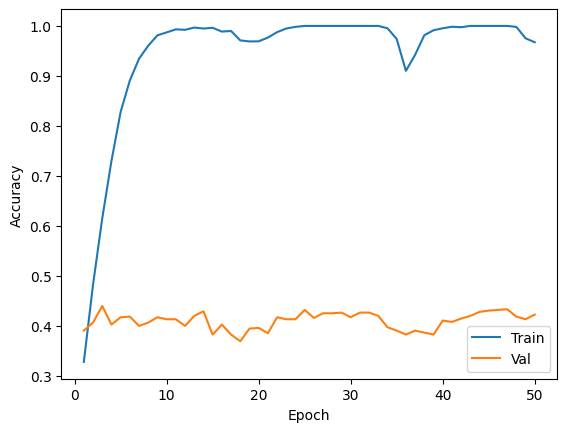

In [ ]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [ ]:
# -------------------------------------------- SVHN Dataset -----------------------------------------------------------
Option = 4
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_SVHN.pt"

model = MLP(3072, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)
        
        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)


    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)

print()
Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 182040794/182040794 [00:04<00:00, 44819126.76it/s]


73257


100%|██████████| 172/172 [00:02<00:00, 73.68it/s]


EPOCH -  1 . Train Accuracy =  0.6322027444839478 , Validation Accuracy =  0.7128037214279175
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 85.17it/s]


EPOCH -  2 . Train Accuracy =  0.7538864612579346 , Validation Accuracy =  0.76622074842453
Model Re-Saved


100%|██████████| 172/172 [00:01<00:00, 86.09it/s]


EPOCH -  3 . Train Accuracy =  0.7898920774459839 , Validation Accuracy =  0.7903357744216919
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 84.54it/s]


EPOCH -  4 . Train Accuracy =  0.8091797232627869 , Validation Accuracy =  0.7957047820091248
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 77.81it/s]


EPOCH -  5 . Train Accuracy =  0.829157829284668 , Validation Accuracy =  0.8019837737083435
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 85.00it/s]


EPOCH -  6 . Train Accuracy =  0.8391148447990417 , Validation Accuracy =  0.8062607645988464
Model Re-Saved


100%|██████████| 172/172 [00:01<00:00, 87.11it/s]


EPOCH -  7 . Train Accuracy =  0.8520106673240662 , Validation Accuracy =  0.8177267909049988
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 69.77it/s]


EPOCH -  8 . Train Accuracy =  0.8593820333480835 , Validation Accuracy =  0.8247337937355042
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 83.77it/s]


EPOCH -  9 . Train Accuracy =  0.8691944479942322 , Validation Accuracy =  0.8240057826042175


100%|██████████| 172/172 [00:02<00:00, 85.45it/s]


EPOCH -  10 . Train Accuracy =  0.8736911416053772 , Validation Accuracy =  0.8352898359298706
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 84.87it/s]


EPOCH -  11 . Train Accuracy =  0.8839532732963562 , Validation Accuracy =  0.831285834312439


100%|██████████| 172/172 [00:02<00:00, 70.14it/s]


EPOCH -  12 . Train Accuracy =  0.8883857131004333 , Validation Accuracy =  0.8319228291511536


100%|██████████| 172/172 [00:01<00:00, 86.49it/s]


EPOCH -  13 . Train Accuracy =  0.8970418572425842 , Validation Accuracy =  0.8349258303642273


100%|██████████| 172/172 [00:01<00:00, 87.24it/s]


EPOCH -  14 . Train Accuracy =  0.9012013077735901 , Validation Accuracy =  0.8363817930221558
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 72.71it/s]


EPOCH -  15 . Train Accuracy =  0.9080426692962646 , Validation Accuracy =  0.8435708284378052
Model Re-Saved


100%|██████████| 172/172 [00:01<00:00, 87.46it/s]


EPOCH -  16 . Train Accuracy =  0.9120094180107117 , Validation Accuracy =  0.8370188474655151


100%|██████████| 172/172 [00:01<00:00, 86.72it/s]


EPOCH -  17 . Train Accuracy =  0.91594398021698 , Validation Accuracy =  0.8391118049621582


100%|██████████| 172/172 [00:02<00:00, 85.83it/s]


EPOCH -  18 . Train Accuracy =  0.9221751093864441 , Validation Accuracy =  0.8457548022270203
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 73.09it/s]


EPOCH -  19 . Train Accuracy =  0.9256279468536377 , Validation Accuracy =  0.8339248299598694


100%|██████████| 172/172 [00:02<00:00, 85.52it/s]


EPOCH -  20 . Train Accuracy =  0.9289201498031616 , Validation Accuracy =  0.8391118049621582


100%|██████████| 172/172 [00:02<00:00, 85.07it/s]


EPOCH -  21 . Train Accuracy =  0.9333044290542603 , Validation Accuracy =  0.8404768109321594


100%|██████████| 172/172 [00:02<00:00, 67.50it/s]


EPOCH -  22 . Train Accuracy =  0.9364360570907593 , Validation Accuracy =  0.8439348340034485


100%|██████████| 172/172 [00:02<00:00, 84.17it/s]


EPOCH -  23 . Train Accuracy =  0.939021646976471 , Validation Accuracy =  0.8402038216590881


100%|██████████| 172/172 [00:02<00:00, 85.64it/s]


EPOCH -  24 . Train Accuracy =  0.9418802857398987 , Validation Accuracy =  0.8446628451347351


100%|██████████| 172/172 [00:02<00:00, 78.89it/s]


EPOCH -  25 . Train Accuracy =  0.9432935118675232 , Validation Accuracy =  0.8507598042488098
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 79.83it/s]


EPOCH -  26 . Train Accuracy =  0.9472923874855042 , Validation Accuracy =  0.8436618447303772


100%|██████████| 172/172 [00:01<00:00, 86.67it/s]


EPOCH -  27 . Train Accuracy =  0.9516445398330688 , Validation Accuracy =  0.8453908562660217


100%|██████████| 172/172 [00:02<00:00, 85.69it/s]


EPOCH -  28 . Train Accuracy =  0.9520781636238098 , Validation Accuracy =  0.8434798121452332


100%|██████████| 172/172 [00:02<00:00, 64.11it/s]


EPOCH -  29 . Train Accuracy =  0.9535235166549683 , Validation Accuracy =  0.841113805770874


100%|██████████| 172/172 [00:02<00:00, 85.75it/s]


EPOCH -  30 . Train Accuracy =  0.9548724889755249 , Validation Accuracy =  0.8405678272247314


100%|██████████| 172/172 [00:01<00:00, 86.24it/s]


EPOCH -  31 . Train Accuracy =  0.9563820958137512 , Validation Accuracy =  0.8412958383560181


100%|██████████| 172/172 [00:01<00:00, 86.12it/s]


EPOCH -  32 . Train Accuracy =  0.9591764807701111 , Validation Accuracy =  0.8444808125495911


100%|██████████| 172/172 [00:02<00:00, 78.01it/s]


EPOCH -  33 . Train Accuracy =  0.9614729881286621 , Validation Accuracy =  0.8453908562660217


100%|██████████| 172/172 [00:01<00:00, 87.13it/s]


EPOCH -  34 . Train Accuracy =  0.9622920751571655 , Validation Accuracy =  0.845663845539093


100%|██████████| 172/172 [00:01<00:00, 86.40it/s]


EPOCH -  35 . Train Accuracy =  0.9630950093269348 , Validation Accuracy =  0.8428428173065186


100%|██████████| 172/172 [00:02<00:00, 63.79it/s]


EPOCH -  36 . Train Accuracy =  0.9649258255958557 , Validation Accuracy =  0.8446628451347351


100%|██████████| 172/172 [00:01<00:00, 87.10it/s]


EPOCH -  37 . Train Accuracy =  0.966997504234314 , Validation Accuracy =  0.8429338335990906


100%|██████████| 172/172 [00:02<00:00, 85.09it/s]


EPOCH -  38 . Train Accuracy =  0.9664996862411499 , Validation Accuracy =  0.8426608443260193


100%|██████████| 172/172 [00:02<00:00, 84.41it/s]


EPOCH -  39 . Train Accuracy =  0.9685232043266296 , Validation Accuracy =  0.8510328531265259
Model Re-Saved


100%|██████████| 172/172 [00:02<00:00, 75.23it/s]


EPOCH -  40 . Train Accuracy =  0.970129132270813 , Validation Accuracy =  0.8415688276290894


100%|██████████| 172/172 [00:02<00:00, 85.49it/s]


EPOCH -  41 . Train Accuracy =  0.9703058004379272 , Validation Accuracy =  0.8450268507003784


100%|██████████| 172/172 [00:02<00:00, 83.67it/s]


EPOCH -  42 . Train Accuracy =  0.9713496565818787 , Validation Accuracy =  0.8470288515090942


100%|██████████| 172/172 [00:02<00:00, 63.81it/s]


EPOCH -  43 . Train Accuracy =  0.9715584516525269 , Validation Accuracy =  0.8470288515090942


100%|██████████| 172/172 [00:02<00:00, 85.14it/s]


EPOCH -  44 . Train Accuracy =  0.9729556441307068 , Validation Accuracy =  0.8518518209457397
Model Re-Saved


100%|██████████| 172/172 [00:01<00:00, 86.42it/s]


EPOCH -  45 . Train Accuracy =  0.9730840921401978 , Validation Accuracy =  0.845572829246521


100%|██████████| 172/172 [00:02<00:00, 77.14it/s]


EPOCH -  46 . Train Accuracy =  0.9749791622161865 , Validation Accuracy =  0.8444808125495911


100%|██████████| 172/172 [00:02<00:00, 85.29it/s]


EPOCH -  47 . Train Accuracy =  0.9743207097053528 , Validation Accuracy =  0.8483028411865234


100%|██████████| 172/172 [00:02<00:00, 85.97it/s]


EPOCH -  48 . Train Accuracy =  0.9748988747596741 , Validation Accuracy =  0.8484848141670227


100%|██████████| 172/172 [00:02<00:00, 82.73it/s]


EPOCH -  49 . Train Accuracy =  0.9773077964782715 , Validation Accuracy =  0.8518518209457397


100%|██████████| 172/172 [00:02<00:00, 72.24it/s]


EPOCH -  50 . Train Accuracy =  0.976424515247345 , Validation Accuracy =  0.8470288515090942



100%|██████████| 973/973 [00:12<00:00, 78.61it/s]


Train Accuracy =  0.975027322769165


100%|██████████| 407/407 [00:04<00:00, 85.83it/s]

Test Accuracy =  0.815957248210907
Generalization Gap =  0.15907007455825806


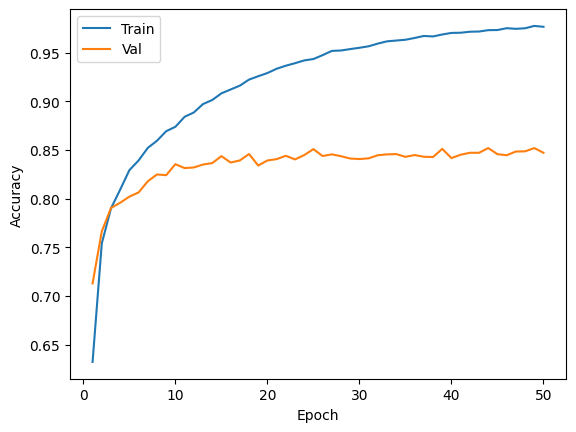

In [ ]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [8]:
# -------------------------------------------- CIFAR-10 Dataset -----------------------------------------------------------
Option = 5
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_CIFAR10.pt"

model = MLP(3072, 10).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)

    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)


print()

Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 170498071/170498071 [00:01<00:00, 88755215.50it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


100%|██████████| 118/118 [00:01<00:00, 88.13it/s]


EPOCH -  1 . Train Accuracy =  0.43385881185531616 , Validation Accuracy =  0.4694666862487793
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.67it/s]


EPOCH -  2 . Train Accuracy =  0.5214353203773499 , Validation Accuracy =  0.503600001335144
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.08it/s]


EPOCH -  3 . Train Accuracy =  0.5621647238731384 , Validation Accuracy =  0.5199999809265137
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 84.94it/s]


EPOCH -  4 . Train Accuracy =  0.6026353240013123 , Validation Accuracy =  0.5269333124160767
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 85.70it/s]


EPOCH -  5 . Train Accuracy =  0.6364470720291138 , Validation Accuracy =  0.5338666439056396
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 69.92it/s]


EPOCH -  6 . Train Accuracy =  0.6688470840454102 , Validation Accuracy =  0.541866660118103
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 63.79it/s]


EPOCH -  7 . Train Accuracy =  0.6937176585197449 , Validation Accuracy =  0.5404000282287598


100%|██████████| 118/118 [00:01<00:00, 88.27it/s]


EPOCH -  8 . Train Accuracy =  0.7279058694839478 , Validation Accuracy =  0.5337333679199219


100%|██████████| 118/118 [00:01<00:00, 85.56it/s]


EPOCH -  9 . Train Accuracy =  0.7553411722183228 , Validation Accuracy =  0.5433333516120911
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.54it/s]


EPOCH -  10 . Train Accuracy =  0.7886117696762085 , Validation Accuracy =  0.5417333245277405


100%|██████████| 118/118 [00:01<00:00, 86.78it/s]


EPOCH -  11 . Train Accuracy =  0.8068000078201294 , Validation Accuracy =  0.5405333638191223


100%|██████████| 118/118 [00:01<00:00, 85.84it/s]


EPOCH -  12 . Train Accuracy =  0.8345646858215332 , Validation Accuracy =  0.536133348941803


100%|██████████| 118/118 [00:01<00:00, 87.42it/s]


EPOCH -  13 . Train Accuracy =  0.8509882688522339 , Validation Accuracy =  0.5402666926383972


100%|██████████| 118/118 [00:01<00:00, 67.91it/s]


EPOCH -  14 . Train Accuracy =  0.8733646869659424 , Validation Accuracy =  0.5311999917030334


100%|██████████| 118/118 [00:01<00:00, 69.66it/s]


EPOCH -  15 . Train Accuracy =  0.8791294097900391 , Validation Accuracy =  0.5248000025749207


100%|██████████| 118/118 [00:01<00:00, 86.72it/s]


EPOCH -  16 . Train Accuracy =  0.893294095993042 , Validation Accuracy =  0.525600016117096


100%|██████████| 118/118 [00:01<00:00, 84.88it/s]


EPOCH -  17 . Train Accuracy =  0.908047080039978 , Validation Accuracy =  0.53493332862854


100%|██████████| 118/118 [00:01<00:00, 86.07it/s]


EPOCH -  18 . Train Accuracy =  0.9111058712005615 , Validation Accuracy =  0.5297333598136902


100%|██████████| 118/118 [00:01<00:00, 87.31it/s]


EPOCH -  19 . Train Accuracy =  0.9035764932632446 , Validation Accuracy =  0.5372000336647034


100%|██████████| 118/118 [00:01<00:00, 87.11it/s]


EPOCH -  20 . Train Accuracy =  0.9405176639556885 , Validation Accuracy =  0.5274666547775269


100%|██████████| 118/118 [00:01<00:00, 86.90it/s]


EPOCH -  21 . Train Accuracy =  0.9277176260948181 , Validation Accuracy =  0.5368000268936157


100%|██████████| 118/118 [00:01<00:00, 62.63it/s]


EPOCH -  22 . Train Accuracy =  0.9394823312759399 , Validation Accuracy =  0.522266685962677


100%|██████████| 118/118 [00:01<00:00, 71.48it/s]


EPOCH -  23 . Train Accuracy =  0.9371058940887451 , Validation Accuracy =  0.547866702079773
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 87.01it/s]


EPOCH -  24 . Train Accuracy =  0.932658851146698 , Validation Accuracy =  0.5338666439056396


100%|██████████| 118/118 [00:01<00:00, 88.05it/s]


EPOCH -  25 . Train Accuracy =  0.948235273361206 , Validation Accuracy =  0.5318666696548462


100%|██████████| 118/118 [00:01<00:00, 85.29it/s]


EPOCH -  26 . Train Accuracy =  0.9485882520675659 , Validation Accuracy =  0.5334666967391968


100%|██████████| 118/118 [00:01<00:00, 87.86it/s]


EPOCH -  27 . Train Accuracy =  0.9469411969184875 , Validation Accuracy =  0.5301333665847778


100%|██████████| 118/118 [00:01<00:00, 87.58it/s]


EPOCH -  28 . Train Accuracy =  0.9433411955833435 , Validation Accuracy =  0.5271999835968018


100%|██████████| 118/118 [00:01<00:00, 85.56it/s]


EPOCH -  29 . Train Accuracy =  0.9502823352813721 , Validation Accuracy =  0.5422666668891907


100%|██████████| 118/118 [00:01<00:00, 61.33it/s]


EPOCH -  30 . Train Accuracy =  0.9491058588027954 , Validation Accuracy =  0.5267999768257141


100%|██████████| 118/118 [00:01<00:00, 75.64it/s]


EPOCH -  31 . Train Accuracy =  0.9657176733016968 , Validation Accuracy =  0.531333327293396


100%|██████████| 118/118 [00:01<00:00, 85.41it/s]


EPOCH -  32 . Train Accuracy =  0.9549411535263062 , Validation Accuracy =  0.5385333299636841


100%|██████████| 118/118 [00:01<00:00, 86.25it/s]


EPOCH -  33 . Train Accuracy =  0.9650588035583496 , Validation Accuracy =  0.5358666777610779


100%|██████████| 118/118 [00:01<00:00, 86.17it/s]


EPOCH -  34 . Train Accuracy =  0.959105908870697 , Validation Accuracy =  0.5288000106811523


100%|██████████| 118/118 [00:01<00:00, 85.64it/s]


EPOCH -  35 . Train Accuracy =  0.9675294160842896 , Validation Accuracy =  0.5398666858673096


100%|██████████| 118/118 [00:01<00:00, 84.81it/s]


EPOCH -  36 . Train Accuracy =  0.9638823866844177 , Validation Accuracy =  0.53493332862854


100%|██████████| 118/118 [00:01<00:00, 81.92it/s]


EPOCH -  37 . Train Accuracy =  0.956847071647644 , Validation Accuracy =  0.5375999808311462


100%|██████████| 118/118 [00:01<00:00, 62.26it/s]


EPOCH -  38 . Train Accuracy =  0.954235315322876 , Validation Accuracy =  0.5360000133514404


100%|██████████| 118/118 [00:01<00:00, 74.81it/s]


EPOCH -  39 . Train Accuracy =  0.9676706194877625 , Validation Accuracy =  0.5366666913032532


100%|██████████| 118/118 [00:01<00:00, 82.97it/s]


EPOCH -  40 . Train Accuracy =  0.9686823487281799 , Validation Accuracy =  0.5305333137512207


100%|██████████| 118/118 [00:01<00:00, 86.76it/s]


EPOCH -  41 . Train Accuracy =  0.9689412117004395 , Validation Accuracy =  0.5281333327293396


100%|██████████| 118/118 [00:01<00:00, 87.48it/s]


EPOCH -  42 . Train Accuracy =  0.9671764969825745 , Validation Accuracy =  0.5400000214576721


100%|██████████| 118/118 [00:01<00:00, 84.95it/s]


EPOCH -  43 . Train Accuracy =  0.9790823459625244 , Validation Accuracy =  0.5337333679199219


100%|██████████| 118/118 [00:01<00:00, 86.25it/s]


EPOCH -  44 . Train Accuracy =  0.9704470634460449 , Validation Accuracy =  0.5303999781608582


100%|██████████| 118/118 [00:01<00:00, 86.34it/s]


EPOCH -  45 . Train Accuracy =  0.9612705707550049 , Validation Accuracy =  0.5383999943733215


100%|██████████| 118/118 [00:01<00:00, 64.87it/s]


EPOCH -  46 . Train Accuracy =  0.973341166973114 , Validation Accuracy =  0.5354666709899902


100%|██████████| 118/118 [00:01<00:00, 78.20it/s]


EPOCH -  47 . Train Accuracy =  0.9682353138923645 , Validation Accuracy =  0.53493332862854


100%|██████████| 118/118 [00:01<00:00, 84.31it/s]


EPOCH -  48 . Train Accuracy =  0.9658588171005249 , Validation Accuracy =  0.541866660118103


100%|██████████| 118/118 [00:01<00:00, 84.22it/s]


EPOCH -  49 . Train Accuracy =  0.9780235290527344 , Validation Accuracy =  0.543066680431366


100%|██████████| 118/118 [00:01<00:00, 86.05it/s]


EPOCH -  50 . Train Accuracy =  0.9665411710739136 , Validation Accuracy =  0.5394666790962219



100%|██████████| 665/665 [00:08<00:00, 77.99it/s]


Train Accuracy =  0.9604941010475159


100%|██████████| 157/157 [00:01<00:00, 86.39it/s]

Test Accuracy =  0.5473999977111816
Generalization Gap =  0.41309410333633423


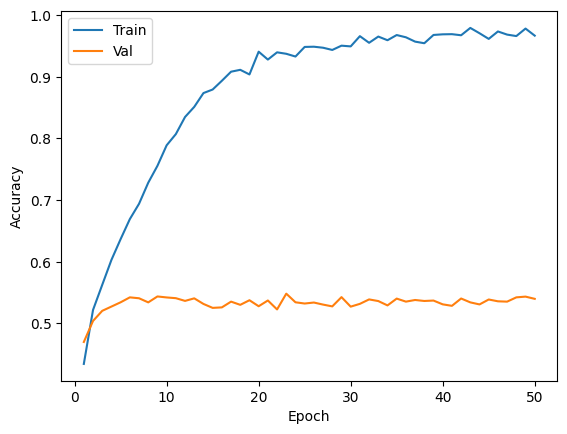

In [9]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)

In [10]:
# -------------------------------------------- CIFAR-100 Dataset -----------------------------------------------------------
Option = 6
Train_DataLoader, Val_DataLoader, Test_DataLoader = CreateDataLoaders(Option, 64)
ModelName = "Model_MLP_CIFAR100.pt"

model = MLP(3072, 100).to(device)
loss_criteria = nn.CrossEntropyLoss()
AdamOpt = torch.optim.Adam(model.parameters(), lr=0.0001)

ValAccuracy = 0
TrainAcc_List = []
ValAcc_List = []

saved = False
if saved == True:
    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)
else:
    model.train()
    Train_Accuracy = 0

    for e in range(EPOCHS):
        Train_Accuracy = TrainModel(model, loss_criteria, AdamOpt, device, Train_DataLoader)
        val_acc = EvaluateModel(model, Val_DataLoader, device)

        TrainAcc_List.append(Train_Accuracy.cpu().item())
        ValAcc_List.append(val_acc.cpu().item())

        print("EPOCH - ", e+1, ". Train Accuracy = ", Train_Accuracy.cpu().item(), ", Validation Accuracy = ", val_acc.cpu().item())
        
        if val_acc.cpu().item() > ValAccuracy:
            print("Model Re-Saved")
            ValAccuracy = val_acc.cpu().item()
            torch.save(model, ModelName)

    saved_model = torch.load(ModelName, map_location=torch.device('cpu')).to(device)


print()

Train_Accuracy = EvaluateModel(saved_model, Train_DataLoader, device)
print("Train Accuracy = ", Train_Accuracy.cpu().item())
Test_Accuracy = EvaluateModel(saved_model, Test_DataLoader, device)
print("Test Accuracy = ", Test_Accuracy.cpu().item())

print("Generalization Gap = ", (Train_Accuracy.cpu().item() - Test_Accuracy.cpu().item()))

100%|██████████| 169001437/169001437 [00:02<00:00, 77920293.48it/s] 


Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


100%|██████████| 118/118 [00:01<00:00, 70.63it/s]


EPOCH -  1 . Train Accuracy =  0.1472705900669098 , Validation Accuracy =  0.18719999492168427
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 84.68it/s]


EPOCH -  2 . Train Accuracy =  0.22444705665111542 , Validation Accuracy =  0.21586667001247406
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 84.26it/s]


EPOCH -  3 . Train Accuracy =  0.26842352747917175 , Validation Accuracy =  0.23440000414848328
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.15it/s]


EPOCH -  4 . Train Accuracy =  0.30880001187324524 , Validation Accuracy =  0.25066667795181274
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 86.45it/s]


EPOCH -  5 . Train Accuracy =  0.3468706011772156 , Validation Accuracy =  0.2531999945640564
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 85.41it/s]


EPOCH -  6 . Train Accuracy =  0.38842353224754333 , Validation Accuracy =  0.26466667652130127
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 85.82it/s]


EPOCH -  7 . Train Accuracy =  0.4304235279560089 , Validation Accuracy =  0.2722666561603546
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 80.47it/s]


EPOCH -  8 . Train Accuracy =  0.4713882505893707 , Validation Accuracy =  0.27239999175071716
Model Re-Saved


100%|██████████| 118/118 [00:02<00:00, 57.77it/s]


EPOCH -  9 . Train Accuracy =  0.5150588154792786 , Validation Accuracy =  0.27426666021347046
Model Re-Saved


100%|██████████| 118/118 [00:01<00:00, 79.88it/s]


EPOCH -  10 . Train Accuracy =  0.5597882270812988 , Validation Accuracy =  0.2693333327770233


100%|██████████| 118/118 [00:01<00:00, 84.07it/s]


EPOCH -  11 . Train Accuracy =  0.6076000332832336 , Validation Accuracy =  0.2612000107765198


100%|██████████| 118/118 [00:01<00:00, 85.47it/s]


EPOCH -  12 . Train Accuracy =  0.6408941149711609 , Validation Accuracy =  0.2671999931335449


100%|██████████| 118/118 [00:01<00:00, 84.68it/s]


EPOCH -  13 . Train Accuracy =  0.6890117526054382 , Validation Accuracy =  0.2722666561603546


100%|██████████| 118/118 [00:01<00:00, 82.82it/s]


EPOCH -  14 . Train Accuracy =  0.7236470580101013 , Validation Accuracy =  0.26213333010673523


100%|██████████| 118/118 [00:01<00:00, 86.37it/s]


EPOCH -  15 . Train Accuracy =  0.7524706125259399 , Validation Accuracy =  0.26333335041999817


100%|██████████| 118/118 [00:01<00:00, 84.62it/s]


EPOCH -  16 . Train Accuracy =  0.7864705920219421 , Validation Accuracy =  0.25600001215934753


100%|██████████| 118/118 [00:01<00:00, 78.56it/s]


EPOCH -  17 . Train Accuracy =  0.8047764897346497 , Validation Accuracy =  0.26026666164398193


100%|██████████| 118/118 [00:01<00:00, 59.99it/s]


EPOCH -  18 . Train Accuracy =  0.8337411880493164 , Validation Accuracy =  0.2572000026702881


100%|██████████| 118/118 [00:01<00:00, 86.76it/s]


EPOCH -  19 . Train Accuracy =  0.8594353199005127 , Validation Accuracy =  0.25760000944137573


100%|██████████| 118/118 [00:01<00:00, 87.03it/s]


EPOCH -  20 . Train Accuracy =  0.869670569896698 , Validation Accuracy =  0.25760000944137573


100%|██████████| 118/118 [00:01<00:00, 86.34it/s]


EPOCH -  21 . Train Accuracy =  0.8789647221565247 , Validation Accuracy =  0.25253334641456604


100%|██████████| 118/118 [00:01<00:00, 84.65it/s]


EPOCH -  22 . Train Accuracy =  0.8997647166252136 , Validation Accuracy =  0.25519999861717224


100%|██████████| 118/118 [00:01<00:00, 82.65it/s]


EPOCH -  23 . Train Accuracy =  0.9111999869346619 , Validation Accuracy =  0.2537333369255066


100%|██████████| 118/118 [00:01<00:00, 83.11it/s]


EPOCH -  24 . Train Accuracy =  0.9131293892860413 , Validation Accuracy =  0.25519999861717224


100%|██████████| 118/118 [00:01<00:00, 82.05it/s]


EPOCH -  25 . Train Accuracy =  0.904658854007721 , Validation Accuracy =  0.25813332200050354


100%|██████████| 118/118 [00:01<00:00, 64.69it/s]


EPOCH -  26 . Train Accuracy =  0.9273882508277893 , Validation Accuracy =  0.26026666164398193


100%|██████████| 118/118 [00:01<00:00, 68.00it/s]


EPOCH -  27 . Train Accuracy =  0.8998117446899414 , Validation Accuracy =  0.25360000133514404


100%|██████████| 118/118 [00:01<00:00, 87.59it/s]


EPOCH -  28 . Train Accuracy =  0.9381647109985352 , Validation Accuracy =  0.25866666436195374


100%|██████████| 118/118 [00:01<00:00, 87.34it/s]


EPOCH -  29 . Train Accuracy =  0.940258800983429 , Validation Accuracy =  0.2534666657447815


100%|██████████| 118/118 [00:01<00:00, 83.84it/s]


EPOCH -  30 . Train Accuracy =  0.9347529411315918 , Validation Accuracy =  0.24960000813007355


100%|██████████| 118/118 [00:01<00:00, 85.83it/s]


EPOCH -  31 . Train Accuracy =  0.9535999894142151 , Validation Accuracy =  0.25280001759529114


100%|██████████| 118/118 [00:01<00:00, 86.40it/s]


EPOCH -  32 . Train Accuracy =  0.9321176409721375 , Validation Accuracy =  0.25519999861717224


100%|██████████| 118/118 [00:01<00:00, 86.32it/s]


EPOCH -  33 . Train Accuracy =  0.9448000192642212 , Validation Accuracy =  0.24986666440963745


100%|██████████| 118/118 [00:01<00:00, 79.59it/s]


EPOCH -  34 . Train Accuracy =  0.95218825340271 , Validation Accuracy =  0.25839999318122864


100%|██████████| 118/118 [00:02<00:00, 57.32it/s]


EPOCH -  35 . Train Accuracy =  0.953458845615387 , Validation Accuracy =  0.25306665897369385


100%|██████████| 118/118 [00:01<00:00, 82.27it/s]


EPOCH -  36 . Train Accuracy =  0.952470600605011 , Validation Accuracy =  0.24666666984558105


100%|██████████| 118/118 [00:01<00:00, 86.58it/s]


EPOCH -  37 . Train Accuracy =  0.9385647177696228 , Validation Accuracy =  0.25546666979789734


100%|██████████| 118/118 [00:01<00:00, 84.31it/s]


EPOCH -  38 . Train Accuracy =  0.9560235142707825 , Validation Accuracy =  0.25679999589920044


100%|██████████| 118/118 [00:01<00:00, 82.11it/s]


EPOCH -  39 . Train Accuracy =  0.9548470377922058 , Validation Accuracy =  0.256933331489563


100%|██████████| 118/118 [00:01<00:00, 84.67it/s]


EPOCH -  40 . Train Accuracy =  0.9640470743179321 , Validation Accuracy =  0.2590666711330414


100%|██████████| 118/118 [00:01<00:00, 86.11it/s]


EPOCH -  41 . Train Accuracy =  0.9543294310569763 , Validation Accuracy =  0.25626668334007263


100%|██████████| 118/118 [00:01<00:00, 85.04it/s]


EPOCH -  42 . Train Accuracy =  0.9709647297859192 , Validation Accuracy =  0.2492000013589859


100%|██████████| 118/118 [00:01<00:00, 62.52it/s]


EPOCH -  43 . Train Accuracy =  0.9744470715522766 , Validation Accuracy =  0.2486666738986969


100%|██████████| 118/118 [00:01<00:00, 73.24it/s]


EPOCH -  44 . Train Accuracy =  0.9603529572486877 , Validation Accuracy =  0.24880000948905945


100%|██████████| 118/118 [00:01<00:00, 84.29it/s]


EPOCH -  45 . Train Accuracy =  0.95783531665802 , Validation Accuracy =  0.2550666630268097


100%|██████████| 118/118 [00:01<00:00, 85.36it/s]


EPOCH -  46 . Train Accuracy =  0.9685882329940796 , Validation Accuracy =  0.24639999866485596


100%|██████████| 118/118 [00:01<00:00, 81.71it/s]


EPOCH -  47 . Train Accuracy =  0.9561647176742554 , Validation Accuracy =  0.2521333396434784


100%|██████████| 118/118 [00:01<00:00, 87.71it/s]


EPOCH -  48 . Train Accuracy =  0.9235059022903442 , Validation Accuracy =  0.2484000027179718


100%|██████████| 118/118 [00:01<00:00, 89.52it/s]


EPOCH -  49 . Train Accuracy =  0.9719294309616089 , Validation Accuracy =  0.25546666979789734


100%|██████████| 118/118 [00:01<00:00, 86.37it/s]


EPOCH -  50 . Train Accuracy =  0.9682588577270508 , Validation Accuracy =  0.25706666707992554



100%|██████████| 665/665 [00:07<00:00, 86.96it/s]


Train Accuracy =  0.5979058742523193


100%|██████████| 157/157 [00:02<00:00, 65.45it/s]

Test Accuracy =  0.27570000290870667
Generalization Gap =  0.32220587134361267


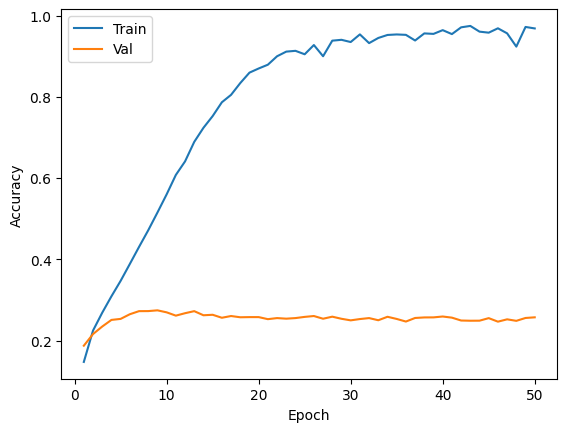

In [11]:
PlotGraph(Epoch_List, TrainAcc_List, ValAcc_List)